In [1]:
from BMI_HBVmountain_Python import *
from Calibration import *
import os
import netCDF4 as nc
from utils import *


## Load forcing data

In [4]:
forcing = pd.read_csv('Data/ThunderCreek/forcing_thundercreek.csv', index_col=[0], parse_dates=True)
pd.to_datetime(forcing.index);
forcing = forcing.reset_index(level=0)
for i in range(len(forcing)):
    forcing['time'][i] = forcing['time'][i].date()
forcing.set_index('time', inplace=True)

C:\Users\Vincent Hoogelander\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Setting up the model

In [3]:
model = BMI_HBVmountain()

In [4]:
config_file = model.setup()

In [5]:
model.initialize(config_file)

### Parameters

In [127]:
bare_parameters, forest_parameters, grass_parameters, rip_parameters,  slow_parameters, parameters_array =  Main.parameter_selection()
model.set_value('bare_parameters', bare_parameters)
model.set_value('forest_parameters', forest_parameters)
model.set_value('grass_parameters', grass_parameters)
model.set_value('rip_parameters', rip_parameters)
model.set_value('slow_parameters', slow_parameters)

In [6]:
param_list = parameter_conversion('output_tc', nsmallest=10)

model.set_value('bare_parameters', param_list[0][0])
model.set_value('forest_parameters', param_list[0][1])
model.set_value('grass_parameters', param_list[0][2])
model.set_value('rip_parameters', param_list[0][3])
model.set_value('slow_parameters', param_list[0][4])


### Forcings

In [7]:
model.set_value('Temperature', (forcing['temp_era5'].values).reshape(len(forcing),1))
model.set_value('Precipitation', (forcing['prec_era5'].values).reshape(len(forcing),1))

model.set_value('Date', list(forcing.index.values))
model.set_value('Current_Date', forcing.index.values[0])

TypeError: <PyCall.jlwrap (in a Julia function called from Python)
JULIA: TypeError: in setfield!, expected Union{Nothing, Matrix{Float64}}, got a value of type Vector{Float64}
Stacktrace:
 [1] set_value(model::HBVmountain_model, name::String, value::Vector{Float64})
   @ Main C:\Users\Vincent Hoogelander\Thesis\HBVmountain\ThunderCreek2\Refactoring\Julia_BMI_model.jl:198
 [2] invokelatest(::Any, ::Any, ::Vararg{Any}; kwargs::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
   @ Base .\essentials.jl:716
 [3] invokelatest(::Any, ::Any, ::Vararg{Any})
   @ Base .\essentials.jl:714
 [4] _pyjlwrap_call(f::Function, args_::Ptr{PyCall.PyObject_struct}, kw_::Ptr{PyCall.PyObject_struct})
   @ PyCall C:\Users\Vincent Hoogelander\.julia\packages\PyCall\7a7w0\src\callback.jl:28
 [5] pyjlwrap_call(self_::Ptr{PyCall.PyObject_struct}, args_::Ptr{PyCall.PyObject_struct}, kw_::Ptr{PyCall.PyObject_struct})
   @ PyCall C:\Users\Vincent Hoogelander\.julia\packages\PyCall\7a7w0\src\callback.jl:44>

### Initial settings

In [11]:
model.set_value('Elevation', Elevations(500, 500, 2500, 1500, 1500)) # 4 Elevation bands

model.set_value('Glacier', [0.0, 0.0, 0.0, 0.6]) # 60% of the area glacier at highest elevation band
model.set_value('Sunhours', [8.87, 10.30, 11.88, 13.65, 15.13, 15.97, 15.58, 14.25, 12.62, 11.87, 9.28, 8.45]) #Seattle
model.set_value('bare_input', HRU_Input([0.0,0.0,0.3,0.7], 0.32, [0.0, 0.0, 0.0, 0.6], [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('forest_input', HRU_Input([0.0,0.7,0.3,0.0], 0.45,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('grass_input', HRU_Input([0.7,0.3,0.0,0.0], 0.21,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('rip_input', HRU_Input([1.0,0.0,0.0,0.0], 0.02,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('Total_Elevationbands', 4)
model.set_value('Elevation_Percentage', [0.15,0.26,0.36,0.23])
model.set_value('bare_storage', Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('forest_storage', Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('grass_storage', Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('rip_storage', Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))

## Running the model

In [12]:
Discharge = []
timestamp = []
while (model.get_value_ptr('Current_Date') < (datetime.date(1999, 1, 1))):  
    model.update()
    timestamp.append(model.get_value_ptr('Current_Date'))
    Discharge.append(model.get_value_ptr('Discharge'))

## Analysis

In [13]:
simulated_discharge_df = pd.DataFrame(
    {'simulation': Discharge},
    index=pd.to_datetime(timestamp)
)
combined_discharge = pd.merge(simulated_discharge_df, forcing['streamflow'], left_index=True, right_index=True)
combined_discharge

,simulation,streamflow
1986-01-02,0.000100,0.971722
1986-01-03,0.000099,0.953927
1986-01-04,0.000098,0.944712
1986-01-05,0.000097,0.944712
1986-01-06,0.000096,0.962825
...,...,...
1998-12-28,1.652948,3.302202
1998-12-29,4.156548,6.505580
1998-12-30,9.045295,8.332087
1998-12-31,6.786346,6.001606


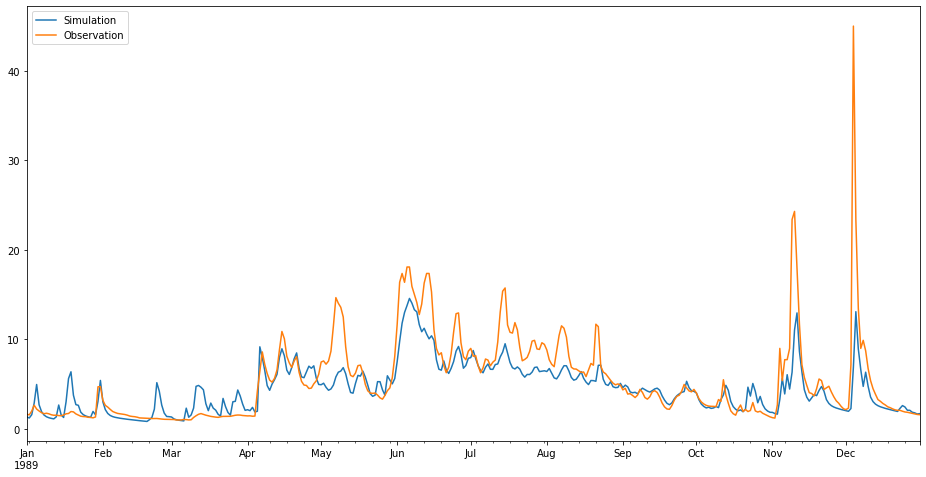

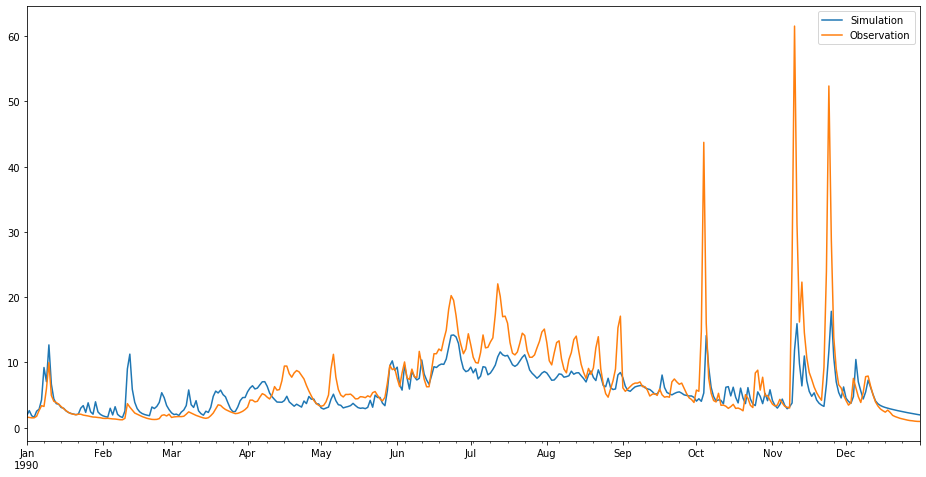

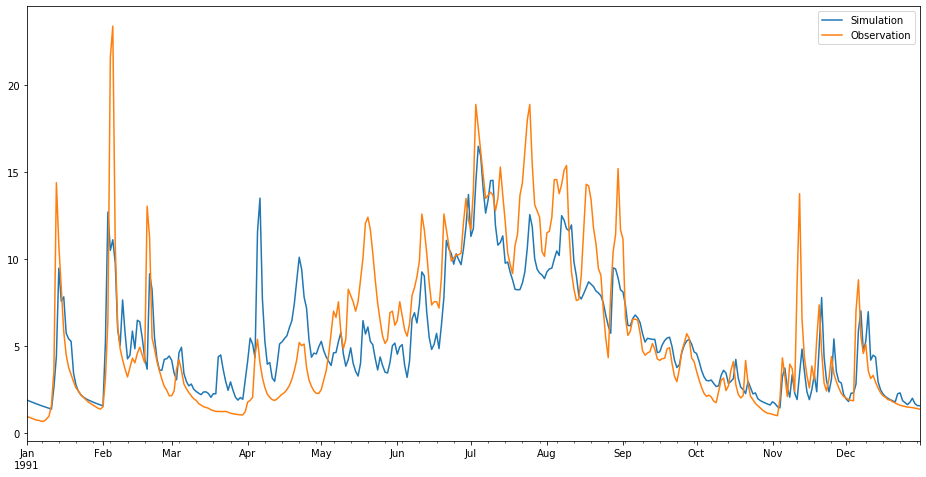

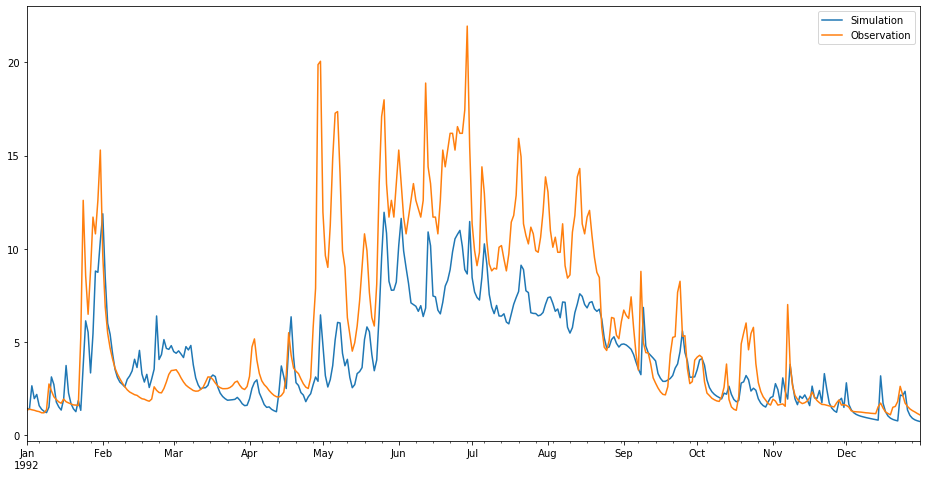

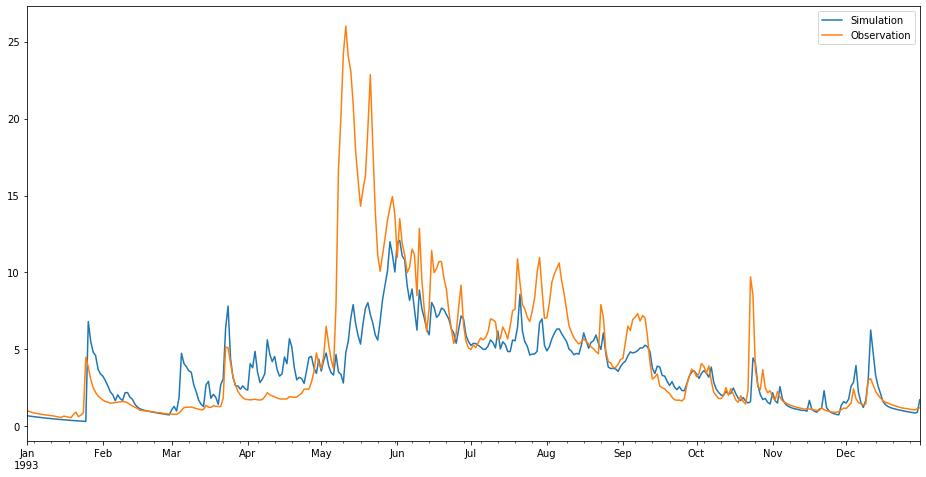

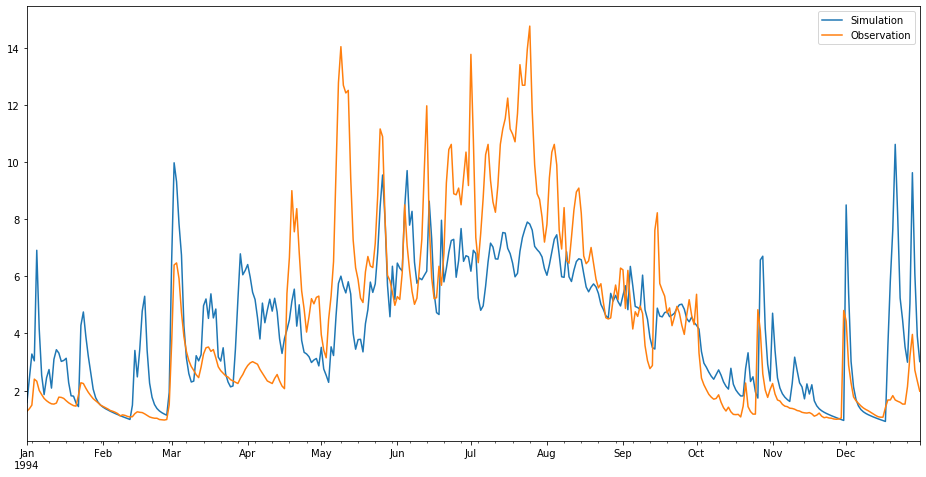

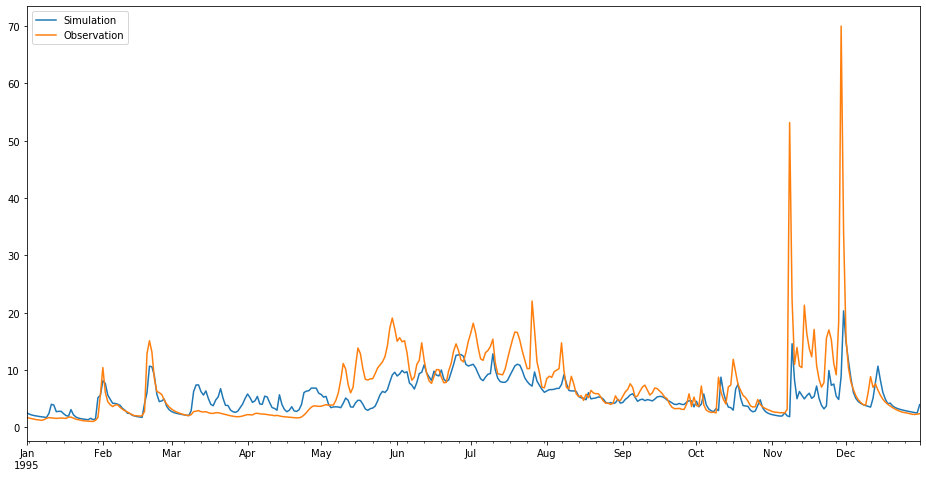

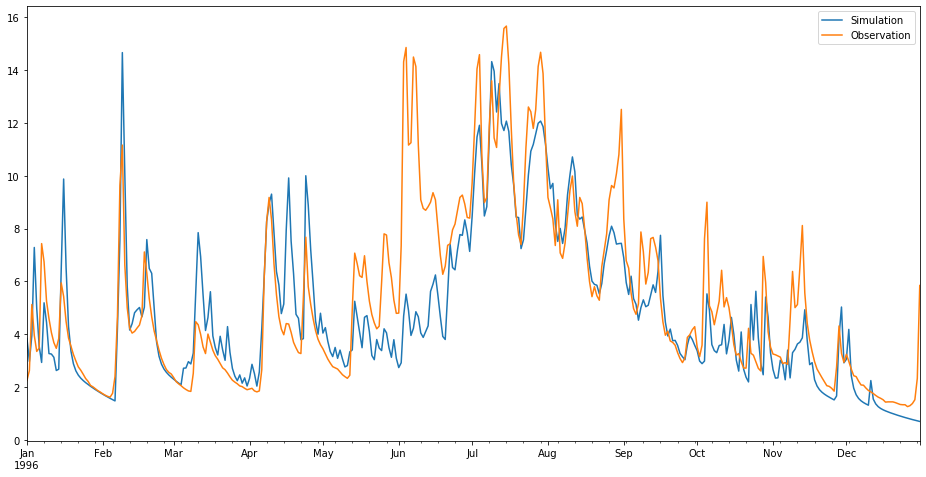

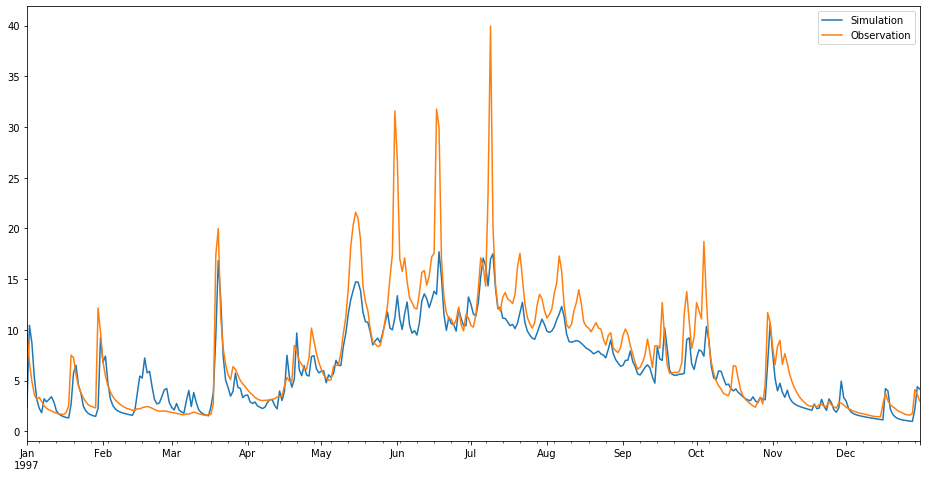

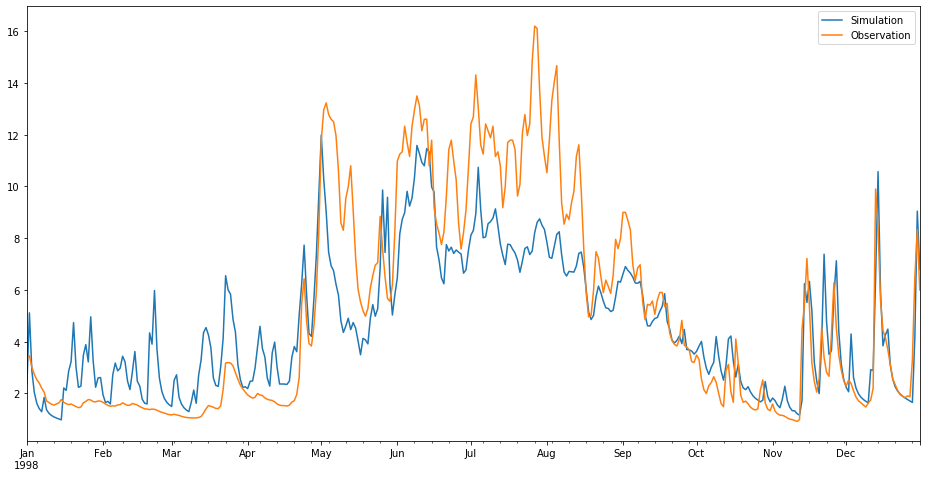

In [14]:
x = [1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998]
for i in x:
    plt.figure(figsize=[16,8])
    combined_discharge.simulation.loc[combined_discharge.index.year == i].plot(label='Simulation')
    combined_discharge.streamflow.loc[combined_discharge.index.year == i].plot(label='Observation')
    plt.legend()

# ED, nse, lognse, nseFDC, nse_runoff

## Clean up

In [15]:
model.finalize()

In [16]:
print(model)

In [22]:
yearlyrunoff(forcing.prec_era5.iloc[731:], combined_discharge.streamflow.iloc[730:]), yearlyrunoff(forcing.prec_era5.iloc[731:], combined_discharge.simulation.iloc[730:])

(time
 1988    0.908843
 1989    0.846303
 1990    0.977602
 1991    0.850097
 1992    0.694928
 1993    0.828919
 1994    1.168713
 1995    0.808094
 1996    1.062718
 1997    0.779014
 1998    1.000232
 1999    0.883524
 2000    0.632760
 2001    0.926080
 2002    0.731942
 2003    0.761611
 2004    0.737390
 2005    0.775625
 Freq: A-DEC, dtype: float64,
 time
 1988    1.140430
 1989    1.093285
 1990    1.297158
 1991    0.991884
 1992    1.079179
 1993    1.114943
 1994    1.367665
 1995    1.122489
 1996    1.254041
 1997    0.988606
 1998    1.257454
 1999    1.107064
 2000    0.958640
 2001    1.435095
 2002    0.970463
 2003    1.233806
 2004    0.991509
 2005    1.167587
 Freq: A-DEC, dtype: float64)

In [121]:
forest = pd.read_csv('output_tc/bare_paramsets.csv', usecols=[1,6,7,8,9,10,11,12,13,14,15])
forest

,ED,beta,Ce,Drainagecapacity,Interceptionstoragecapacity,Kf,Meltfactor,Mm,Ratio_Pref,Soilstoragecapacity,Temp_Thresh
0,0.361023,1.898,0.545,0.0,0.0,0.656,2.726,0.6579,0.356,12.34,0.580
1,0.519229,0.756,0.762,0.0,0.0,0.638,2.731,0.2073,0.516,27.08,-1.734
2,0.517428,0.458,0.539,0.0,0.0,0.631,3.730,0.2199,0.345,22.71,-0.176
3,0.350555,0.699,0.694,0.0,0.0,0.908,4.916,0.9147,0.475,5.33,-0.008
4,0.554377,0.531,0.760,0.0,0.0,0.642,3.508,0.2220,0.150,17.17,-1.976
...,...,...,...,...,...,...,...,...,...,...,...
261,0.599919,0.187,0.737,0.0,0.0,0.760,4.410,0.1040,0.219,21.06,-1.703
262,0.547576,1.142,0.450,0.0,0.0,0.416,3.275,0.5401,0.709,3.07,-1.993
263,0.428713,0.350,0.652,0.0,0.0,0.271,3.133,0.6743,0.673,27.41,-0.022
264,0.396042,0.730,0.605,0.0,0.0,0.836,2.161,0.7437,0.126,11.82,1.076


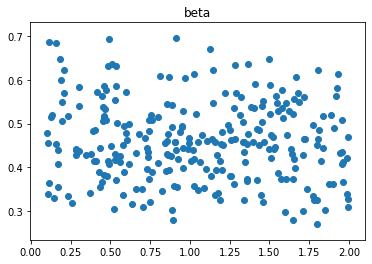

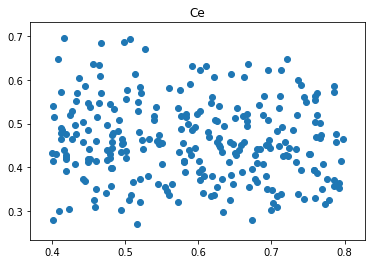

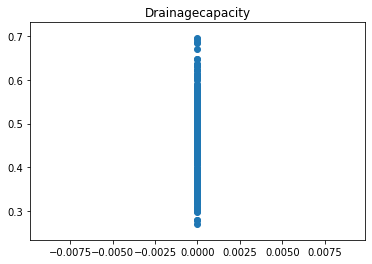

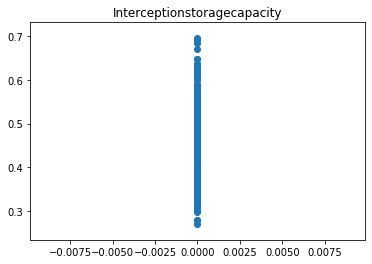

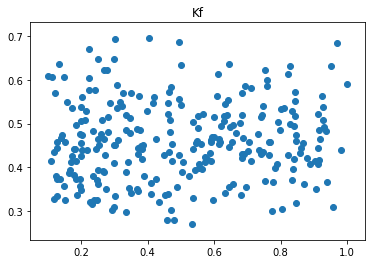

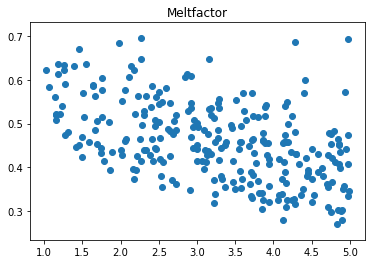

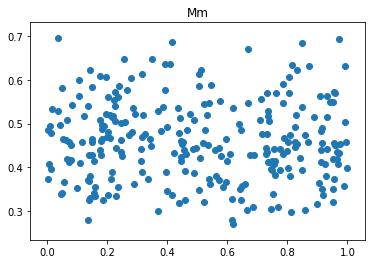

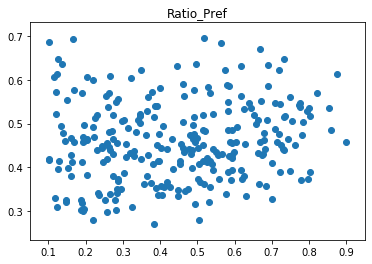

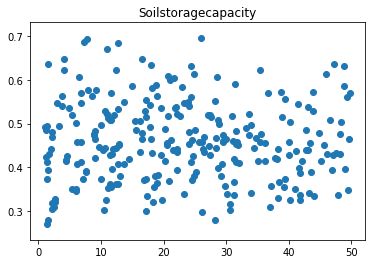

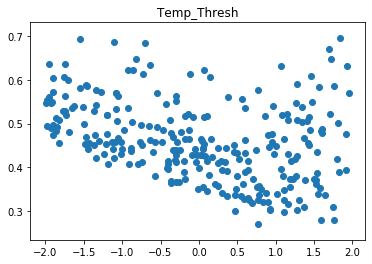

In [122]:
for i in range(1,11):
    plt.figure()
    plt.scatter(forest.iloc[:,i], forest.ED)
    plt.title(forest.columns[i])

In [123]:
forest.ED.nsmallest(30)

57     0.271090
156    0.280865
50     0.281038
110    0.298671
243    0.301574
121    0.302047
168    0.302093
214    0.304647
115    0.308613
98     0.309905
36     0.315592
166    0.317923
225    0.320441
172    0.321993
89     0.324622
66     0.324818
106    0.325792
120    0.326315
141    0.327417
92     0.329329
86     0.334864
148    0.335044
15     0.335854
80     0.336344
119    0.337405
159    0.339043
116    0.339831
251    0.341142
183    0.342305
130    0.347022
Name: ED, dtype: float64

Text(0, 0.5, 'mm day-1')

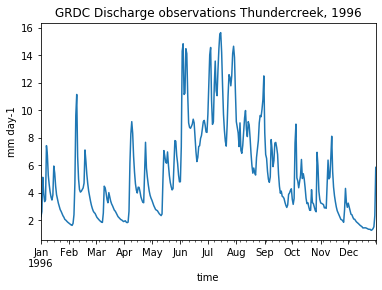

In [7]:
forcing.index = pd.to_datetime(forcing.index)
forcing.streamflow.loc[forcing.index.year == 1996].plot()
plt.title('GRDC Discharge observations Thundercreek, 1996')
plt.ylabel('mm day-1')

In [3]:
generate_landuse_per_elevation('Data/dem_thundercreek.tif', 'Data/nlcd_thundercreek.tif')

[[[0.15, 0.312, 0.416, 0.122],
  [0.317, 0.456, 0.214, 0.013],
  587.5,
  396.0,
  2746.0,
  1572.355],
 [[0.001, 0.066, 0.7, 0.234], [0.0, 0.021, 0.222, 0.074]],
 [[0.001, 0.083, 0.636, 0.28]],
 [[0.217, 0.396, 0.368, 0.02]],
 [[0.077, 0.263, 0.546, 0.113]],
 [[0.65, 0.096, 0.232, 0.023]]]

In [8]:
generate_landuse_per_elevation('Data/dem_thundercreek.tif', 'Data/nlcd_thundercreek.tif')

[[[0.15, 0.312, 0.416, 0.122],
  [0.317, 0.456, 0.214, 0.013],
  587.5,
  396.0,
  2746.0,
  1572.355],
 [[0.001, 0.067, 0.706, 0.227], [0.0, 0.021, 0.224, 0.072]],
 [[0.001, 0.083, 0.636, 0.28]],
 [[0.217, 0.396, 0.368, 0.02]],
 [[0.077, 0.263, 0.546, 0.114]],
 [[0.65, 0.096, 0.232, 0.023]]]

In [2]:
def generate_array_from_raster(str_path_to_rasterfile):
    raster = rasterio.open(str_path_to_rasterfile)
    arr = raster.read(masked=True)
    arr = np.expand_dims(arr.flatten(), 0).T
    
    return arr

def get_elevations_from_raster(raster_array_flattened, nbands):
   
    n, bins, patches = plt.hist(raster_array_flattened, bins=nbands)
    plt.close()
    tot_pixels = n.sum()
    av_elevation = round(raster_array_flattened.mean(),3)
    
    elevation_list = []
    for i in range(nbands):
        elevation_percentage = n[i] / tot_pixels
        elevation_list.append(round(elevation_percentage, 3))
    min_elevation = np.min(bins)
    max_elevation = np.max(bins)
    return elevation_list, bins, min_elevation, max_elevation, av_elevation
def get_landuse_from_raster(raster_array_flattened):
    n, bins, patches = plt.hist(raster_array_flattened, bins=np.arange(96))
    plt.close()
    
    tot_pixels = n.sum()
    
    bare = np.sum(n[[12, 22, 22, 24, 31]]) / tot_pixels 
    forest = np.sum(n[40:46]) / tot_pixels 
    grass = (np.sum(n[50:83])+ n[21]) /tot_pixels 
    rip = np.sum(n[[11, 90, 94]]) /tot_pixels  
    
    

    landuse_list = [round(bare,3), round(forest,3), round(grass,3), round(rip,3)] 
    return landuse_list



In [10]:
x = generate_array_from_raster('Data/nlcd_thundercreek.tif')

In [13]:
n, bins, patches = plt.hist(x, bins=np.arange(96))
plt.close()

tot_pixels = n.sum()

bare = np.sum(n[[12, 22, 22, 24, 31]]) / tot_pixels 
forest = np.sum(n[40:46]) / tot_pixels 
grass = (np.sum(n[50:83])+ n[21]) /tot_pixels 
rip = np.sum(n[[11, 90, 94]]) /tot_pixels  

np.sum(n[12]) / np.sum(n[[12, 22, 22, 24, 31]])

0.35867307975723145

In [8]:
def run_model_cma(parameters):

    ob_list = []
    params_list = []
    

    forcing = nc.Dataset('Data/ThunderCreek/HBVmountain_ERA5_ThunderCreek_1986_2005.nc') #Catchment dependent
    model = BMI_HBVmountain(forcing_netcdf=forcing)
    config_file = model.setup(forcing_netcdf=forcing, bare_parameters=  Parameters(parameters[8], parameters[6], 0, 0, parameters[4],
                                                                     parameters[1], parameters[2], parameters[3], parameters[7], parameters[0]),
                                        forest_parameters=Parameters(parameters[11], parameters[6], 0, parameters[9], parameters[4],
                                                                     parameters[1], parameters[2], parameters[3], parameters[10], parameters[0]),
                                        grass_parameters= Parameters(parameters[14], parameters[6], 0, parameters[12], parameters[4],
                                                                     parameters[1], parameters[2], parameters[3], parameters[13], parameters[0]),
                                        rip_parameters=   Parameters(parameters[17], parameters[6], 0, parameters[15], parameters[18],
                                                                     parameters[1], parameters[2], parameters[3], parameters[16], parameters[0]),
                                        slow_parameters=  Slow_Paramters(parameters[5], parameters[19]))
    model.initialize(config_file)



########### Catchment dependent settings ######################

    model.set_value('Elevation', Main.Elevations(587.5, 396.0, 2746.0, 1572.36, 1572.36))
    model.set_value('Glacier', [0.0, 0.066, 0.7, 0.234])
    model.set_value('Sunhours', [8.87, 10.30, 11.88, 13.65, 15.13, 15.97, 15.58, 14.25, 12.62, 11.87, 9.28, 8.45]) #Seattle
    model.set_value('bare_input', Main.HRU_Input([0.001, 0.083, 0.636, 0.28], 0.32, [0.0, 0.021, 0.222, 0.074], [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
    model.set_value('forest_input', Main.HRU_Input([0.216, 0.396, 0.368, 0.02], 0.46,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
    model.set_value('grass_input', Main.HRU_Input([0.077, 0.263, 0.546, 0.114], 0.21,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
    model.set_value('rip_input', Main.HRU_Input([0.65, 0.096, 0.232, 0.022], 0.01,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
    model.set_value('Total_Elevationbands', 4)
    model.set_value('Elevation_Percentage', [0.15, 0.312, 0.416, 0.122])
 


    Discharge = []
    timestamp = []
    while (model.get_value_ptr('Current_Date') < (datetime.date(1998, 12, 31))):  
        model.update()
        timestamp.append(model.get_value_ptr('Current_Date'))
        Discharge.append(model.get_value_ptr('Discharge'))

    simulated_discharge_df = pd.DataFrame(
            {'streamflow': Discharge},
            index=pd.to_datetime(timestamp)
        )
    
    precipitation = generate_forcing_from_NETCDF(forcing).prec
    model.finalize()
    return simulated_discharge_df.streamflow, precipitation



def transform(scaled_parameters):
    """Transforms the scaled_parameter to parameter.

    if x = scaled_parameter and y = parameter,
    then x is in the range [0, 10] and y is in the range [a, b].
    To map the values [0, 10] into [a, b],
    we use the transformations a + (b-a) * x/10.
    For more information on this transformation,
    please see
    http://cma.gforge.inria.fr/cmaes_sourcecode_page.html#practical
    """
    PARAMETERS_BOUNDS = [[-2.0, 2.0],
                 [1.0, 5.0],
                 [0.001, 1.0],
                 [0.1, 0.9],
                 [0.1, 3.0],
                 [0.001, 0.1],
                 [0.4, 0.8],
                 [1.0, 75.0],
                 [0.1, 2.0],
                 [1.0, 10.0],
                 [50.0, 750.0],
                 [0.1, 2.0],
                 [0.1, 5.0],
                 [5.0, 400.0],
                 [0.1, 2.0],
                 [0.1, 8.0],
                 [5.0, 400.0],
                 [0.1, 2.0],
                 [0.1, 3.0],
                 [0.05, 0.5]]
    parameters = []
    for scaled_parameter, bound in zip(scaled_parameters, PARAMETERS_BOUNDS):
        scale = (bound[1] - bound[0]) / 10.0
        parameter = bound[0] + (scale * scaled_parameter)
        parameters.append(parameter)
    return parameters

def wrapped_objective_function(scaled_parameters, observation):
    """A wrapper around the objective function.

    The wrapper transforms the scaled_parameters before
    the actual function call.
    """
    parameters = transform(scaled_parameters)
    Qmodelled, precipitation = run_model_cma(parameters)
    precipitation.index, Qmodelled.index, observation.index = pd.to_datetime(precipitation.index), pd.to_datetime(Qmodelled.index), pd.to_datetime(observation.index)
    mask = (observation.index >= Qmodelled.index[0]) & (observation.index <= Qmodelled.index[-1])
    observation = observation.loc[mask]

    ED = multi_objective(Qmodelled.loc[Qmodelled.index.year >= 1989], observation.loc[observation.index.year >= 1989], precipitation)[1] 
    return ED

def cma_calibration(parameter_bounds, observation):
    """Return the optimum parameters found by CMA-ES method."""
    # Set some options for optimization needed when multiprocessing
    options = cma.CMAOptions()
    options.set({
        'bounds': [0, 10],  # for scaled parameters
#         'seed': 1234,  # set a seed to reproduce results
        'verbose': -9,  # verbosity of initial/final message: maximally quiet
        'popsize': POPSIZE,
        'maxiter': MAXITER,
        'tolfun': 1e-17,  # very small value due to model creeping behavior
        'tolx': 1e-5
    #         'verb_filenameprefix': ('output_dir'),  # cma-es output path
    })

    no_of_variables = len(parameter_bounds)
    # initial mean value and standard deviation
    x0 = 5.0
    sigma0 = 2.0

    # Initialize the CMA-ES
    cma_es = cma.CMAEvolutionStrategy(no_of_variables * [x0], sigma0, options)

    # Store the results of each iteration
    all_scores = []
    all_parameters = []

    # Use parallel processing
    # with EvalParallel2(number_of_processes=options['popsize']) as evaluations:
        # Use ask-and-tell interface
    while not cma_es.stop():
        solutions = cma_es.ask()
        cma_es.tell(
            solutions,

            [wrapped_objective_function(x, observation) for x in solutions]
                #function_values=wrapped_objective_function(solutions, observation, area)
            )#,

        # Use transform to return parameters and not scaled ones
        all_parameters.append(transform(cma_es.best.last.x))
        all_scores.append(cma_es.best.last.f)
#     print(f"---- CMA-ES stopped due to: {cma_es.stop()} ----")

    # Make full output
    full_output = (transform(cma_es.result.xbest),
                   cma_es.result.fbest,
                   all_parameters,
                   all_scores)
    return full_output


def full_calibration(ntimes):
    PARAMETERS_BOUNDS = [[-2.0, 2.0],
                     [1.0, 5.0],
                     [0.001, 1.0],
                     [0.1, 0.9],
                     [0.1, 3.0],
                     [0.001, 0.1],
                     [0.4, 0.8],
                     [1.0, 75.0],
                     [0.1, 2.0],
                     [1.0, 10.0],
                     [50.0, 750.0],
                     [0.1, 2.0],
                     [0.1, 5.0],
                     [5.0, 400.0],
                     [0.1, 2.0],
                     [0.1, 8.0],
                     [5.0, 400.0],
                     [0.1, 2.0],
                     [0.1, 3.0],
                     [0.05, 0.5]]
    area = 271.9 #km2
    observation = pd.read_csv('Data/ThunderCreek/Discharge_ThunderCreek.csv', index_col=0).streamflow / (area * 1e6) * 1000 *86400
    ob_list = []
    params_list = []
    results_doc_list = []
    for n in range(ntimes):
        full_output = cma_calibration(PARAMETERS_BOUNDS, observation)
        best_par, best_score, pars, scores = full_output
        
        simulated_discharge, precipitation = run_model_cma(best_par)
        mask = (observation.index >= simulated_discharge.index[0]) & (observation.index <= simulated_discharge.index[-1])
        observation = observation.loc[mask]
        
        objective_function = multi_objective(simulated_discharge.loc[simulated_discharge.index.year >= 1989], observation.loc[observation.index.year >= 1989], precipitation)
        ob_list.append(objective_function)
        params_list.append(best_par)   
        

        
        
        other_values = [
            ([float(z) for z in x], float(1 - y)) for x, y in zip(pars, scores)
        ]
        results_doc = {
            'title': f'HBVmountain model optimized parameter based on ED,{n+1}st simulation',
            'best_parameter_value': [float(x) for x in best_par],
            'best_NSE_value': float(1 - best_score),
            'other_values': other_values,
        }

        results_doc_list.append(results_doc)
    paramset = pd.DataFrame(columns=['ED', 'NSE', 'logNSE', 'NSEfdc', 'NSErunoff', 'Temp_Thresh', 'Meltfactor', 'Mm', 'Ratio_Pref', 'Kf', 'Ks', 'Ce', 'Soilstoragecapacity_Bare', 'beta_Bare', 'Interceptioncapacity_Forest', 'Soilstoragecapacity_Forest', 'beta_Forest', 'Interceptioncapacity_Grass', 'Soilstoragecapacity_Grass', 'beta_Grass', 'Interceptioncapacity_Rip', 'Soilstoragecapacity_Rip', 'beta_Rip', 'Kf_Rip', 'Ratio_Riparian'])
    for i in range(len(ob_list)):
        print(ob_list)
        paramset.loc[i] = [ob_list[i][0], ob_list[i][1], ob_list[i][2], ob_list[i][3], ob_list[i][4], params_list[i][0], params_list[i][1], params_list[i][2], params_list[i][3], params_list[i][4], params_list[i][5], params_list[i][6], params_list[i][7], params_list[i][8], params_list[i][9], params_list[i][10], params_list[i][11], params_list[i][12], params_list[i][13], params_list[i][14], params_list[i][15], params_list[i][16], params_list[i][17], params_list[i][18], params_list[i][19]]

    filename = 'cma_calibration_thundercreek.yml'
    yaml = YAML()
    yaml.default_flow_style = False
    with open(filename, 'w+') as f:
        yaml.dump(results_doc_list, f)
    print(f'Calibration results saved in {filename}')
    return paramset


In [9]:
y = full_calibration(1)

KeyboardInterrupt: 

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])